<a href="https://colab.research.google.com/github/khlose/homl_ageron/blob/master/classification_ch3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LOAD MNIST


In [0]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784")


# Exploring data

In [2]:

X,y = mnist['data'],mnist['target']

print("X:" , X.shape , " Y: " , y.shape)

X: (70000, 784)  Y:  (70000,)


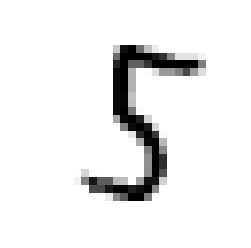

Index 5200 is a hand-written of number:  6


In [3]:
#Print out number
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

some_digit = X[3500]
some_digit_img = some_digit.reshape(28,28)

plt.imshow(some_digit_img, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

print("Index 5200 is a hand-written of number: ", y[52000])

#Splitting Data
(Mnist data has already bee splitted into train and test in 60K- 10K ratio)

In [0]:
X_train, X_test, y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

#shuffle as well (ensuring that cross validation fold will be even across all folds)

import numpy as np

shuffle_index = np.random.permutation(60000)

X_train,y_train = X_train[shuffle_index],y_train[shuffle_index]

#Simple binary classifier


In [5]:
# basically a detector that separate 5 and non-5 digit

y_train_5 = y_train == '5'
y_test_5 = y_test == '5'


from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [6]:
#predict
sgd_clf.predict([some_digit])

array([ True])

# SGD performance measure


In [7]:
# We need more contol over cross-validation process
# Implement it myself

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits =3,random_state=42)

for train_index,test_index in skfolds.split(X_train,y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_folds = X_train[test_index]
  y_test_folds = y_train_5[test_index]
  
  clone_clf.fit(X_train_folds,y_train_folds)
  y_pred = clone_clf.predict(X_test_folds)
  
  n_correct = sum(y_pred == y_test_folds)
  
  print(n_correct/len(y_pred))

0.9375
0.96605
0.96045


In [8]:
#premade cross_val_score

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.9375 , 0.96605, 0.96045])

In [9]:
#try out an estimator that always return false,
#the accuracy of this one is also at about 90%!,
#the reason is the amount of 5 is 10% of all numbers.
#this is why accuracy is not always the best measurement
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self,X,y=None):
    pass
  def predict(self,X):
    return np.zeros((len(X),1),dtype=bool)

never_5_clf = Never5Classifier()

cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.91155, 0.90885, 0.90855])

# Confusion Matrix

In [10]:
#basically measure the frequency of mis-prediction
#class 5's being identified as class 3's

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix


y_train_predict = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

confusion_matrix(y_train_5, y_train_predict)

array([[52814,  1765],
       [  955,  4466]])

# Performance measurement


In [14]:
# precision and recall

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_train_5,y_train_predict)
recall = recall_score(y_train_5,y_train_predict)

#print(precision, recall)
# 0.7167388862140909 0.8238332410994281
# this means it was righ 72 percent of the time and could only detect
# 82 percent of all the 5's


0.7167388862140909 0.8238332410994281


In [16]:
from sklearn.metrics import f1_score

f1 = f1_score(y_train_5, y_train_predict)
print(f1)

0.7665636800549264


# Tuning recall and precision trade-off


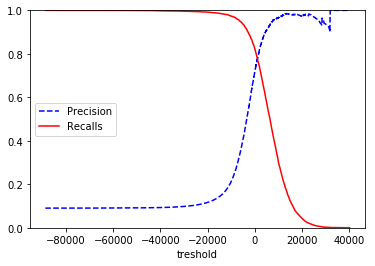

In [20]:
#see the precision/recall tradeoff curve

from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")
precisions,recalls,thresholds = precision_recall_curve(y_train_5, y_scores)


#plot the curve

def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
  plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
  plt.plot(thresholds,recalls[:-1],"r-",label="Recalls")
  plt.xlabel("treshold")
  plt.legend(loc="center left")
  plt.ylim([0,1])
  
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()
#adjusting threshold to get better (or worse) precision/recall